In [1]:
import torch
import torchvision
import argparse
import pickle
from argparse import Namespace

from PIL import Image as PIL_Image
from models.End_ExpansionNet_v2 import End_ExpansionNet_v2
from utils.language_utils import convert_vector_idx2word

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from time import time

%matplotlib inline


### Checkpoint and dictionary paths

In [2]:
load_path = 'checkpoints/kaz_model.pth'
dict_path = 'vocabulary/vocab_kz.pickle'


### Model

In [3]:
drop_args = Namespace(enc=0.0,
                      dec=0.0,
                      enc_input=0.0,
                      dec_input=0.0,
                      other=0.0)
model_args = Namespace(model_dim=512,
                       N_enc=3,
                       N_dec=3,
                       dropout=0.0,
                       drop_args=drop_args)


with open(dict_path, 'rb') as f:
    coco_tokens = pickle.load(f)
print("Dictionary loaded ...")


img_size = 384
model = End_ExpansionNet_v2(swin_img_size=img_size, swin_patch_size=4, swin_in_chans=3,
                                swin_embed_dim=192, swin_depths=[2, 2, 18, 2], swin_num_heads=[6, 12, 24, 48],
                                swin_window_size=12, swin_mlp_ratio=4., swin_qkv_bias=True, swin_qk_scale=None,
                                swin_drop_rate=0.0, swin_attn_drop_rate=0.0, swin_drop_path_rate=0.0,
                                swin_norm_layer=torch.nn.LayerNorm, swin_ape=False, swin_patch_norm=True,
                                swin_use_checkpoint=False,
                                final_swin_dim=1536,

                                d_model=model_args.model_dim, N_enc=model_args.N_enc,
                                N_dec=model_args.N_dec, num_heads=8, ff=2048,
                                num_exp_enc_list=[32, 64, 128, 256, 512],
                                num_exp_dec=16,
                                output_word2idx=coco_tokens['word2idx_dict'],
                                output_idx2word=coco_tokens['idx2word_list'],
                                max_seq_len=63, drop_args=model_args.drop_args,
                                rank=0)

device = torch.device('cuda')
model.to(device)

checkpoint = torch.load(load_path)
model.load_state_dict(checkpoint['model_state_dict'])
print("Model loaded ...")

transf_1 = torchvision.transforms.Compose([torchvision.transforms.Resize((img_size, img_size))])
transf_2 = torchvision.transforms.Compose([torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                                                std=[0.229, 0.224, 0.225])])


Dictionary loaded ...
Model loaded ...


### Beam search configuration

In [4]:
beam_search_kwargs = {'beam_size': 5,
                      'beam_max_seq_len': 63,
                      'sample_or_max': 'max',
                      'how_many_outputs': 1,
                      'sos_idx': coco_tokens['word2idx_dict'][coco_tokens['sos_str']],
                      'eos_idx': coco_tokens['word2idx_dict'][coco_tokens['eos_str']]}


### Caption generation

In [5]:
def generate_caption(path):
    start = time()

    pil_image = PIL_Image.open(path)
    if pil_image.mode != 'RGB':
        pil_image = PIL_Image.new("RGB", pil_image.size)
    preprocess_pil_image = transf_1(pil_image)
    tens_image_1 = torchvision.transforms.ToTensor()(preprocess_pil_image)
    tens_image_2 = transf_2(tens_image_1)

    image = tens_image_2.unsqueeze(0).cuda()
    with torch.no_grad():
        pred, _ = model(enc_x=image,
                        enc_x_num_pads=[0],
                        mode='beam_search', **beam_search_kwargs)
    pred = convert_vector_idx2word(pred[0][0], coco_tokens['idx2word_list'])[1:-1]
    pred[-1] = pred[-1] + '.'
    pred = ' '.join(pred).capitalize()
    stop = time()
    
    img = mpimg.imread(path)
    imgplot = plt.imshow(img)
    plt.axis('off')
    plt.show()

    print('\nDescription: ' + pred)
    print('Time: {:.4f}s\n'.format(stop-start))

    return pred
    

### Inference

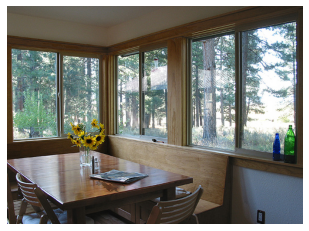


Description: Ағаш үстел мен гүлдері бар асхана.
Time: 0.1405s



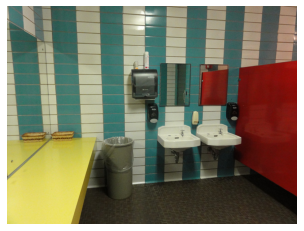


Description: Екі раковина және айна бар ванна бөлмесі.
Time: 0.1754s



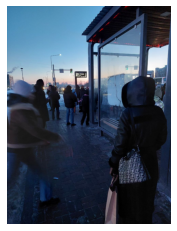


Description: Жаңбыр астында тұрған бір топ адам.
Time: 0.1472s



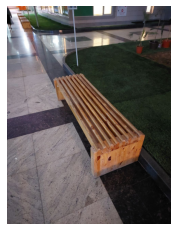


Description: Жанында отырған ағаш орындық.
Time: 0.1598s



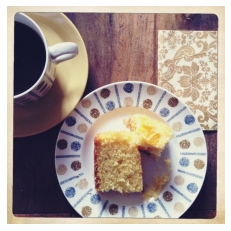


Description: Торттың бір бөлігі пен кофе.
Time: 0.1380s



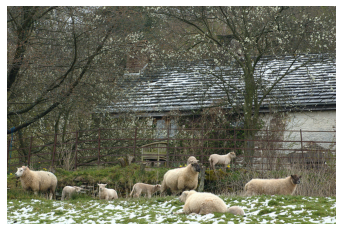


Description: Далада жайылып жүрген бір отар қой.
Time: 0.1343s



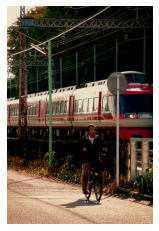


Description: Пойыздың қасында велосипедпен келе жатқан адам.
Time: 0.1541s



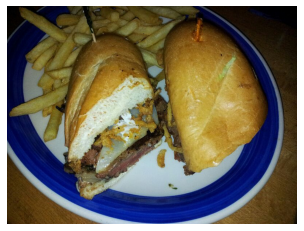


Description: Сэндвич пен картоп салынған көк және ақ табақ.
Time: 0.1593s



In [9]:
import os
IMAGES_DIR = 'example_images'

for img_name in os.listdir(IMAGES_DIR):
    generate_caption(os.path.join(IMAGES_DIR, img_name))